In [83]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [84]:
(X, y), (_, _) = mnist.load_data()
X = X.reshape(-1, 28 * 28) / 255.0
print(X.shape)

X = X[:100]
y = y[:100]


(60000, 784)


In [51]:
def pairwise_distances(X): # Shape of X: (n, d)

    # the squared norms of each data point (||x_i||^2 for each i)
    sum_X = np.sum(np.square(X), axis=1)  # Shape: (n,)
    # distances[i, j] = ||x_i||^2 + ||x_j||^2 - 2(x_i ⋅ x_j)
    dot_products = np.dot(X, X.T) # Shape: (n, n)
    # ||x_j||^2 - 2(x_i ⋅ x_j)
    intermediate_sum = np.add(-2 * dot_products, sum_X).T # Shape: (n, n)
    # ||x_i||^2 + ||x_j||^2 - 2(x_i ⋅ x_j)
    return np.add(intermediate_sum, sum_X) # Shape: (n, n)

D = pairwise_distances(X)

In [38]:
def Hbeta(Di, beta):

    # Di is the distance vector from point i to all other points, excluding the point itself
    # beta = 1 / sigma^2, the bandwidth parameter for each point's Gaussian distribution, controlling spread

    # Compute Gaussian similarity with beta as the bandwidth (P_{j|i})
    P = np.exp(-Di * beta)
    
    # Normalize to get a probability distribution
    sumP = np.sum(P)
    P /= sumP
    
    # Compute Shannon entropy H
    H = -np.sum(P * np.log(P + 1e-10))  # Adding a small constant to avoid log(0)

    return H, P

def compute_perplexity(D, perplexity):

    # D is the pairwise distance matrix (Shape: (n, n))
    # perplexity is a user-defined value that controls the effective number of neighbors to consider
    (n, _) = D.shape  # n is the number of data points
    P = np.zeros((n, n))  # Initialize similarity matrix P with zeros (Shape: (n, n))
    
    # Initialize all betas to 1 (Shape: (n, 1))
    beta = np.ones((n, 1))  
    
    # logU represents the target entropy for the Gaussian distribution,
    # calculated as the log of the user-defined perplexity value
    logU = np.log(perplexity)  # Compute the natural logarithm of the perplexity

    # Binary search for the right beta
    for i in range(n):
        
        # Set initial binary search bounds for beta for point i
        betamin = -np.inf
        betamax = np.inf
        
        # Di is the distance vector from point i to all other points, excluding the point itself
        # This ensures we're only comparing point i to its neighbors
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        
        # Compute entropy (H) and conditional probabilities (thisP) for the current beta[i]
        H, thisP = Hbeta(Di, beta[i])

        # Calculate the difference between current entropy H and target entropy logU
        # Hdiff tells us if the entropy H is greater or smaller than the target
        Hdiff = H - logU
        tries = 0  # Counter to limit binary search attempts

        # Binary search to find the beta value that brings H close to logU
        while np.abs(Hdiff) > 1e-5 and tries < 50:
            if Hdiff > 0:
                # If H is greater than logU, increase beta to narrow distribution (decrease entropy)
                betamin = beta[i].copy()
                # If betamax is undefined, double beta; else set it as the midpoint
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                # If H is less than logU, decrease beta to widen distribution (increase entropy)
                betamax = beta[i].copy()
                # If betamin is undefined, halve beta; else set it as the midpoint
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2

            # Recalculate entropy and probabilities with the updated beta
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU  # Update Hdiff to check convergence
            tries += 1  # Increment the search attempt counter

        # Store computed probabilities in row i of P for all neighbors (excluding i itself)
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    return P  # Return the probability matrix P based on computed betas

def symmetrize_P(P):
    # Symmetrize P matrix
    P = (P + P.T) / (2 * P.shape[0])
    return P

perplexity = 30
P = compute_perplexity(D, perplexity)
P = symmetrize_P(P)


In [39]:
def compute_Q(Y):

    # Compute low-dimensional similarities (Q matrix)

    n = Y.shape[0]  # Number of data points in low-dimensional space
    sum_Y = np.sum(np.square(Y), axis=1)  # Squared norms of each data point (Shape: (n,))
    
    # Compute pairwise squared Euclidean distances
    Q = pairwise_distances(Y)  # Shape: (n, n)
    
    # Convert distances to similarities using the logistic function
    Q = 1 / (1 + Q)  # Shape: (n, n)
    
    np.fill_diagonal(Q, 0)  # Set diagonal elements to 0 (no self-similarity)
    
    # Normalize to ensure the probabilities sum to 1
    Q /= np.sum(Q)  # Shape: (n, n)
    
    return Q

num_dimensions = 2 # Number of dimensions for low-dimensional space
Y = np.random.randn(X.shape[0], num_dimensions)  # Initialize Y randomly
Q = compute_Q(Y)

In [40]:
def compute_gradient(P, Q, Y):
    # Compute the gradient
    
    n = Y.shape[0]
    grad = np.zeros(Y.shape)
    
    for i in range(n):
        # Compute the squared distance from Y[i] to all other points
        dist = np.linalg.norm(Y[i, :] - Y, axis=1)
        
        # Compute the gradient contribution from point i
        PQ_diff = P[:, i] - Q[:, i]  # Shape: (n,)
        grad[i, :] = np.sum(np.tile(PQ_diff, (Y.shape[1], 1)).T * (Y[i, :] - Y), axis=0) / (n-1)

    return grad


def tsne(X, num_dimensions=2, perplexity=30.0, learning_rate=200.0, num_iterations=1000):

    # t-SNE algorithm
    
    (n, d) = X.shape
    Y = np.random.randn(n, num_dimensions)
    P = pairwise_distances(X)
    P = compute_perplexity(P, perplexity)
    P = symmetrize_P(P)
    P *= 4.0
    P = np.maximum(P, 1e-12)

    for iteration in range(num_iterations):
        Q = compute_Q(Y)
        Q = np.maximum(Q, 1e-12)

        # Compute the gradient
        grad = compute_gradient(P, Q, Y)

        # Update Y using gradient descent
        Y -= learning_rate * grad

        if iteration % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {iteration}: Error = {C}")

        if iteration == 100:
            P /= 4.0

    return Y

In [85]:
def visualize_embedding(Y, labels):
    # Visualize the embedding
    plt.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='Spectral', s=1)
    plt.colorbar()
    plt.title('t-SNE embedding of the MNIST dataset')
    plt.show()

Iteration 0: Error = 19.82857599501389
Iteration 100: Error = 19.683549560082064
Iteration 200: Error = 3.5276488457371333
Iteration 300: Error = 3.5210937153023467
Iteration 400: Error = 3.5146430564257445
Iteration 500: Error = 3.5082946528259367
Iteration 600: Error = 3.5020463301876266
Iteration 700: Error = 3.495895954996291
Iteration 800: Error = 3.489841433263871
Iteration 900: Error = 3.483880709234648


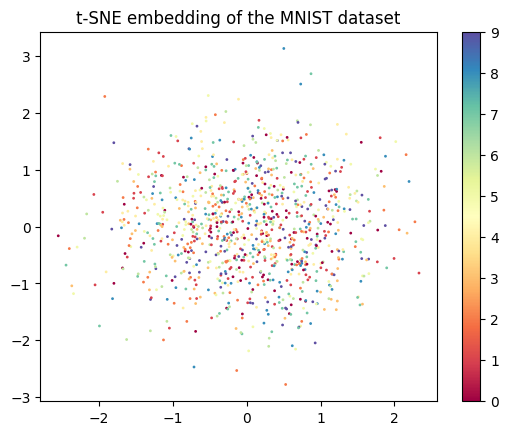

In [42]:
Y = tsne(X, num_iterations=1000)
visualize_embedding(Y, y)

In [46]:
def compute_gradient_closed_form(P, Q, Y):
    n = Y.shape[0]
    grad = np.zeros(Y.shape)

    for i in range(n):
        # Compute the gradient contribution for each point
        for j in range(n):
            if i != j:  # Skip self-term
                # Compute the difference vector
                diff = Y[i, :] - Y[j, :]
                distance_squared = np.dot(diff, diff)  # ||y_i - y_j||^2
                # Update the gradient using the closed-form equation
                grad[i, :] += 4 * (P[i, j] - Q[i, j]) * diff * (1 + distance_squared) ** -1

    return grad

def tsne_closed_form(X, num_dimensions=2, perplexity=30.0, learning_rate=200.0, num_iterations=1000):

    # t-SNE algorithm
    
    (n, d) = X.shape
   
    D = pairwise_distances(X)
    P = compute_perplexity(D, perplexity)
    P = symmetrize_P(P)
    P = np.maximum(P, 1e-12) # Avoid division by zero

    Y = np.random.randn(0, 1e-4, (n, num_dimensions))

    for iteration in range(num_iterations):
        Q = compute_Q(Y)
        Q = np.maximum(Q, 1e-12) # Avoid division by zero

        # Compute the gradient
        grad = compute_gradient_closed_form(P, Q, Y)

        # Update Y using gradient descent
        Y -= learning_rate * grad

        if iteration % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {iteration}: Error = {C}")

        if iteration == 100:
            P /= 4.0

    return Y

In [47]:
Y = tsne_closed_form(X, num_iterations=1000)
visualize_embedding(Y, y)

/tmp/ipykernel_6613/3808428470.py:38: RuntimeWarning: divide by zero encountered in log
  C = np.sum(P * np.log(P / Q))
/tmp/ipykernel_6613/3808428470.py:38: RuntimeWarning: invalid value encountered in multiply
  C = np.sum(P * np.log(P / Q))


Iteration 0: Error = nan


KeyboardInterrupt: 

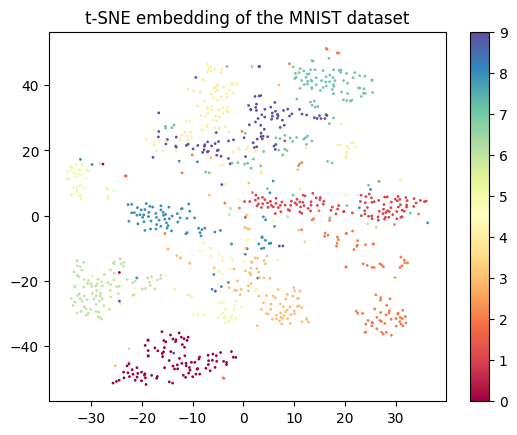

In [50]:
# use t-SNE from scikit-learn
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30.0, learning_rate=200.0, max_iter=1000)
Y = tsne.fit_transform(X)
visualize_embedding(Y, y)

In [109]:
def get_dists(X):
    """Return squared Euclidean pairwise distances."""
    
    n = X.shape[0]
    dists = np.zeros([n, n])
    
    for i in range(n):
        for j in range(i, n):
            dists[i, j] = np.sum((X[i, :] - X[j, :])**2)

    return dists + dists.T

In [87]:
def get_pij(d, scale, i):
    """
    Compute probabilities conditioned on point i from a row of distances
    d and a Gaussian scale (scale = 2*sigma^2). 
    """
    
    d_scaled = -d/scale
    d_scaled -= np.max(d_scaled)
    exp_D = np.exp(d_scaled)
    exp_D[i] = 0
    
    return exp_D/np.sum(exp_D)


In [88]:
def get_entropy(p):    
    """Calculates 2 ** H(p) of array p, where H(p) is the Shannon entropy."""
    return 2 ** np.sum(-p*np.log2(p+1e-10))

In [147]:
def get_P(D, target_perp = 30, LB = 0, UB = 1e4, tol = 1e-6, maxit = 250):
    """Optimize standard deviations to target perplexities with binary search. 
    Returns joint probabilities."""

    n = D.shape[0]
    P = np.zeros(D.shape)
    
    for i in range(n):
        LB_i = LB
        UB_i = UB
        d = D[i, :]
        
        for t in range(maxit):
            # Find the perplexity using sigma = midpoint.
            midpoint = (LB_i + UB_i)/2
            scale = 2*midpoint**2
            p_ij = get_pij(d, scale, i)
            current_perp = get_entropy(p_ij)

            if current_perp < target_perp:
                LB_i = midpoint
            else:
                UB_i = midpoint

            if np.abs(current_perp-target_perp) < tol:
                break
            
        P[i,:] = p_ij
        
    return (P+P.T)/(2*n)

In [148]:
def get_Q(Y, df=1):

    D = get_dists(Y)
    Q = np.power(1 + D/df, -1)
    np.fill_diagonal(Q, 0)
    return Q/np.sum(Q)

In [149]:
def get_grad(R, Y, df=1):
    """Compute the t-SNE gradient with raw Python."""

    n = Y.shape[0]
    dY = np.zeros(shape = Y.shape)

    Q = np.power(1 + D/df, -1)
    
    for i in range(n):
        for j in range(n):
            dY[i,:] += 4*R[i,j]*(Y[i, :] - Y[j, :])*Q[i, j]

    return dY

In [150]:
def constant(t, eta_init, last_eta, c = 100):
    """Constant learning rate."""
    return c

def tsne(X, niter = 1000, alpha_init = 0.5, alpha_final = 0.8, alpha_thr = 250, 
         eta_init = 100, lr_fun = constant, d = 2, exg = 4, exg_thr = 50, 
         perplexity = 30, pca_dims = 30, optim = "fastest", verbose = True, df = 1):
    """Run t-SNE.
    
    Required inputs: 
        X - NxM matrix
    
    Optional inputs:
        d - dimension of embedding
        perplexity - target perplexity
        niter - number of iterations
        alpha_int - initial value of momentum
        alpha_final - final value of momentum term
        alpha_thr - iteration when momentum changes
        eta_init - initial learning rate
        lr_fun - learning rate function
        exg - multiplicative factor for early exaggeration
        exg_thr - iteration to stop exaggeration
        pca_dims - maximum number of dimensions before preprocessing with PCA
        optim - "none", "fast", or "fastest". Which level of optimization to run
        verbose - bool, whether or not to print a progress bar
        df - degrees of freedom of scaled t-distribution, df=1 is usual t-SNE
    
    Outputs:
        Y - (niter + 2) x N x d array of embeddings for each iteration"""
    
    # Get affinities with exaggeration.
    D = get_dists(X)    
    pij = exg*get_P(D, perplexity)
    
    # Initialize first few iterations.
    size = (pij.shape[0], d)
    Y = np.zeros(shape = (niter + 2, size[0], d))
    initial_vals = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y[0, :, :] = Y_m1 = Y[1, :, :] = Y_m2 = initial_vals
    
    last_eta = eta_init
    alpha = alpha_init
    
    for i in range(2, niter + 2):

        print(f"Iteration {i-2}/{niter}")
        
        if i == int(alpha_thr):
            # Reduce momentum after some time.
            alpha = alpha_final
        
        if i == int(exg_thr):
            # Stop the exaggeration.
            pij /= exg
        
        # Compute gradient.
        Y_dists = get_Y_dists(Y_m1, df)
        qij = get_Q(Y_dists)
        rij = pij - qij
        grad = get_grad(rij, Y_dists, Y_m1)
        
        # # Update learning rate.
        # eta = lr_fun(i, eta_init, last_eta)
        # last_eta = eta
        eta = eta_init
        
        # Update embeddings.
        Y_new = Y_m1 - eta*grad + alpha*(Y_m1 - Y_m2)
        Y_m2, Y_m1 = Y_m1, Y_new
        Y[i, :, :] = Y_new
    
    return Y

In [151]:
def tsne_base(X, niter = 1000, eta = 100, d = 2, perplexity = 30):
    
    """Run t-SNE.
    
    Required inputs: 
        X - NxM matrix
    
    Optional inputs:
        d - dimension of embedding
        perplexity - target perplexity
        niter - number of iterations
        eta - learning rate
        lr_fun - learning rate function
    
    Outputs:
        Y - (niter) x N x d array of embeddings for each iteration"""
    
    D = get_dists(X)    
    pij = get_P(D, perplexity)
    
    size = (pij.shape[0], d)
    Y_list = np.zeros(shape = (niter, size[0], d))

    Y = np.random.normal(0.0, np.sqrt(1e-4), size)
    Y_list[0, :, :] = Y

    for i in range(0, niter):

        print(f"Iteration {i+1}/{niter}")
        
        # Compute gradient.
        qij = get_Q(Y)
        rij = pij - qij
        grad = get_grad(rij, Y)
        
        # Update embeddings.
        Y_new = Y - eta*grad
        Y_list[i, :, :] = Y_new

        Y = Y_new
    
    return Y_list

In [152]:
Y_list = tsne_base(X)
visualize_embedding(Y_list[-1], y)

Iteration 1/1000
Iteration 2/1000
Iteration 3/1000
Iteration 4/1000
Iteration 5/1000
Iteration 6/1000
Iteration 7/1000
Iteration 8/1000
Iteration 9/1000
Iteration 10/1000
Iteration 11/1000
Iteration 12/1000
Iteration 13/1000
Iteration 14/1000
Iteration 15/1000
Iteration 16/1000
Iteration 17/1000
Iteration 18/1000
Iteration 19/1000
Iteration 20/1000
Iteration 21/1000
Iteration 22/1000
Iteration 23/1000
Iteration 24/1000
Iteration 25/1000
Iteration 26/1000
Iteration 27/1000
Iteration 28/1000
Iteration 29/1000
Iteration 30/1000
Iteration 31/1000


KeyboardInterrupt: 